<a href="https://colab.research.google.com/github/ckgpeace/EVA6/blob/main/Session8/Session8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook to train a CNN model on CIFAR10 dataset

### Import impoertant libraries

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np

### 1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [3]:
import torch
import torchvision

### 2. Calculate the the mean and Standard devition of the CIFAR10 data

In [4]:
from torchvision import datasets, transforms

train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

# cifar10 Train
print(f"Train Statistics: \n")
train_set = datasets.CIFAR10(root='../data/', train=True, download=True, transform=train_transform)
print(train_set.data.shape)
print(train_set.data.mean(axis=(0,1,2))/255)
print(train_set.data.std(axis=(0,1,2))/255)

# cifar10 test
print(f"Test Statistics: \n")
test_set = datasets.CIFAR10(root='../data/', train=False, download=True, transform=test_transform)
print(test_set.data.shape)
print(test_set.data.mean(axis=(0,1,2))/255)
print(test_set.data.std(axis=(0,1,2))/255)

Train Statistics: 

Files already downloaded and verified
(50000, 32, 32, 3)
[0.49139968 0.48215841 0.44653091]
[0.24703223 0.24348513 0.26158784]
Test Statistics: 

Files already downloaded and verified
(10000, 32, 32, 3)
[0.49421428 0.48513139 0.45040909]
[0.24665252 0.24289226 0.26159238]


### 3. Use latest Albumentations library for Data Augmentation
Link to github - https://github.com/albu/albumentations

### 4. Create Train and test loaders using albumentations_transforms
The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [6]:
# import sys
# del sys.modules['main']

In [7]:
from main import albumentations_transforms
# Train Data Transformations
train_transform = albumentations_transforms(p=1.0, is_train=True)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2, pin_memory= True)


# Train Data Transformations
test_transform = albumentations_transforms(p=1.0, is_train=False)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2, pin_memory= True)

# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### 5. Display some of the images in the data
Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

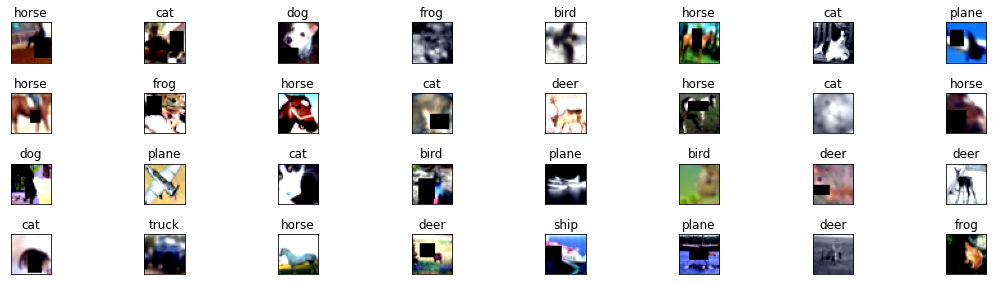

In [9]:
# display impages of the samples from data
# import sys
# del sys.modules['main']
from main import display_sample
display_sample(trainloader, count = 32)

### 6. Define a Convolution Neural Network
Import the model from the model_vanilla.py file which contains the model


In [10]:
# Custom model file
from resnet import ResNet18, ResNet34

In [11]:
# Model Summary
from torchsummary import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18().to(device)
# model = ResNet34().to(device)
print(summary(model, (3,32,32)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### 7. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [14]:
from main import loss_optim

lr=0.001
momentum=0.9
weight_decay=0.001

# Loss Optimizer
criterion, optimizer = loss_optim(model, lr, momentum,weight_decay)

### 8. Train and Test the network


This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [15]:
# Import train and test library
from utils import train, test, plot_misclassified_images, plot_graph

In [16]:
# Train the network for given number of epochs

epochs  = 20
test_losses = []
test_accs = []
misclassified_imgs = []

for epoch in range(epochs):
      print("EPOCH:", epoch+1)
      train(model, device, trainloader, criterion, optimizer, epoch)
      test(model, device, testloader, criterion, classes, test_losses, test_accs, misclassified_imgs, epoch==epochs-1)

  0%|          | 0/1563 [00:00<?, ?it/s]

EPOCH: 1


Loss=1.5158889293670654 Batch_id=1562 Accuracy=41.00: 100%|██████████| 1563/1563 [01:04<00:00, 24.05it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0425, Accuracy: 5138/10000 (51.38%)

EPOCH: 2


Loss=0.6397888660430908 Batch_id=1562 Accuracy=55.17: 100%|██████████| 1563/1563 [01:05<00:00, 23.81it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0305, Accuracy: 6599/10000 (65.99%)

EPOCH: 3


Loss=0.7653380632400513 Batch_id=1562 Accuracy=62.92: 100%|██████████| 1563/1563 [01:06<00:00, 23.58it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0246, Accuracy: 7261/10000 (72.61%)

EPOCH: 4


Loss=1.211204171180725 Batch_id=1562 Accuracy=67.27: 100%|██████████| 1563/1563 [01:06<00:00, 23.57it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0213, Accuracy: 7649/10000 (76.49%)

EPOCH: 5


Loss=0.6296624541282654 Batch_id=1562 Accuracy=69.99: 100%|██████████| 1563/1563 [01:05<00:00, 23.69it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0187, Accuracy: 7951/10000 (79.51%)

EPOCH: 6


Loss=0.5936504602432251 Batch_id=1562 Accuracy=71.69: 100%|██████████| 1563/1563 [01:05<00:00, 23.85it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0177, Accuracy: 8064/10000 (80.64%)

EPOCH: 7


Loss=0.5206217765808105 Batch_id=1562 Accuracy=73.82: 100%|██████████| 1563/1563 [01:05<00:00, 23.83it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0173, Accuracy: 8136/10000 (81.36%)

EPOCH: 8


Loss=0.5181593894958496 Batch_id=1562 Accuracy=75.26: 100%|██████████| 1563/1563 [01:06<00:00, 23.65it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0155, Accuracy: 8250/10000 (82.50%)

EPOCH: 9


Loss=0.5307517051696777 Batch_id=1562 Accuracy=76.43: 100%|██████████| 1563/1563 [01:05<00:00, 23.77it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0151, Accuracy: 8344/10000 (83.44%)

EPOCH: 10


Loss=0.7693837285041809 Batch_id=1562 Accuracy=77.11: 100%|██████████| 1563/1563 [01:05<00:00, 23.77it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0150, Accuracy: 8351/10000 (83.51%)

EPOCH: 11


Loss=0.7462232112884521 Batch_id=1562 Accuracy=78.30: 100%|██████████| 1563/1563 [01:05<00:00, 23.81it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0139, Accuracy: 8470/10000 (84.70%)

EPOCH: 12


Loss=0.7547357678413391 Batch_id=1562 Accuracy=78.92: 100%|██████████| 1563/1563 [01:06<00:00, 23.61it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]

Test set: Average loss: 0.0144, Accuracy: 8446/10000 (84.46%)

EPOCH: 13


Loss=0.734711766242981 Batch_id=1562 Accuracy=79.69: 100%|██████████| 1563/1563 [01:06<00:00, 23.67it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 78 %
Accuracy of   car : 89 %
Accuracy of  bird : 78 %
Accuracy of   cat : 72 %
Accuracy of  deer : 85 %
Accuracy of   dog : 77 %
Accuracy of  frog : 93 %
Accuracy of horse : 90 %
Accuracy of  ship : 96 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0129, Accuracy: 8579/10000 (85.79%)

EPOCH: 14


Loss=0.8299893736839294 Batch_id=1562 Accuracy=80.29: 100%|██████████| 1563/1563 [01:05<00:00, 23.69it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 95 %
Accuracy of  bird : 81 %
Accuracy of   cat : 68 %
Accuracy of  deer : 84 %
Accuracy of   dog : 76 %
Accuracy of  frog : 95 %
Accuracy of horse : 88 %
Accuracy of  ship : 96 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0126, Accuracy: 8633/10000 (86.33%)

EPOCH: 15


Loss=0.38477450609207153 Batch_id=1562 Accuracy=80.83: 100%|██████████| 1563/1563 [01:06<00:00, 23.67it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 84 %
Accuracy of   car : 98 %
Accuracy of  bird : 76 %
Accuracy of   cat : 74 %
Accuracy of  deer : 84 %
Accuracy of   dog : 80 %
Accuracy of  frog : 90 %
Accuracy of horse : 94 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0119, Accuracy: 8683/10000 (86.83%)

EPOCH: 16


Loss=0.9710529446601868 Batch_id=1562 Accuracy=81.55: 100%|██████████| 1563/1563 [01:06<00:00, 23.57it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 83 %
Accuracy of   car : 95 %
Accuracy of  bird : 76 %
Accuracy of   cat : 63 %
Accuracy of  deer : 82 %
Accuracy of   dog : 83 %
Accuracy of  frog : 95 %
Accuracy of horse : 95 %
Accuracy of  ship : 97 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0122, Accuracy: 8687/10000 (86.87%)

EPOCH: 17


Loss=0.30956393480300903 Batch_id=1562 Accuracy=81.79: 100%|██████████| 1563/1563 [01:06<00:00, 23.63it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 94 %
Accuracy of   car : 96 %
Accuracy of  bird : 73 %
Accuracy of   cat : 72 %
Accuracy of  deer : 90 %
Accuracy of   dog : 72 %
Accuracy of  frog : 89 %
Accuracy of horse : 90 %
Accuracy of  ship : 90 %
Accuracy of truck : 92 %

Test set: Average loss: 0.0124, Accuracy: 8622/10000 (86.22%)

EPOCH: 18


Loss=1.0959954261779785 Batch_id=1562 Accuracy=82.41: 100%|██████████| 1563/1563 [01:06<00:00, 23.64it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 80 %
Accuracy of   car : 94 %
Accuracy of  bird : 88 %
Accuracy of   cat : 72 %
Accuracy of  deer : 81 %
Accuracy of   dog : 74 %
Accuracy of  frog : 90 %
Accuracy of horse : 83 %
Accuracy of  ship : 92 %
Accuracy of truck : 94 %

Test set: Average loss: 0.0118, Accuracy: 8688/10000 (86.88%)

EPOCH: 19


Loss=0.7172470092773438 Batch_id=1562 Accuracy=82.88: 100%|██████████| 1563/1563 [01:06<00:00, 23.68it/s]
  0%|          | 0/1563 [00:00<?, ?it/s]


Accuracy of plane : 81 %
Accuracy of   car : 96 %
Accuracy of  bird : 77 %
Accuracy of   cat : 88 %
Accuracy of  deer : 75 %
Accuracy of   dog : 76 %
Accuracy of  frog : 85 %
Accuracy of horse : 82 %
Accuracy of  ship : 95 %
Accuracy of truck : 95 %

Test set: Average loss: 0.0120, Accuracy: 8654/10000 (86.54%)

EPOCH: 20


Loss=0.20333915948867798 Batch_id=1562 Accuracy=83.15: 100%|██████████| 1563/1563 [01:06<00:00, 23.67it/s]



Accuracy of plane : 84 %
Accuracy of   car : 98 %
Accuracy of  bird : 81 %
Accuracy of   cat : 72 %
Accuracy of  deer : 73 %
Accuracy of   dog : 86 %
Accuracy of  frog : 80 %
Accuracy of horse : 96 %
Accuracy of  ship : 91 %
Accuracy of truck : 91 %

Test set: Average loss: 0.0121, Accuracy: 8676/10000 (86.76%)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

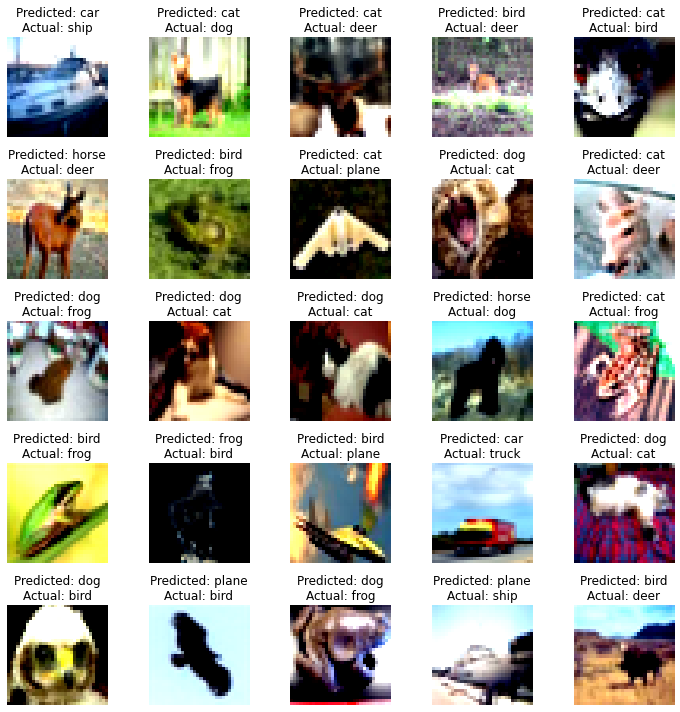

In [17]:
plot_misclassified_images(misclassified_imgs, classes, "misclassified_imgs.png")

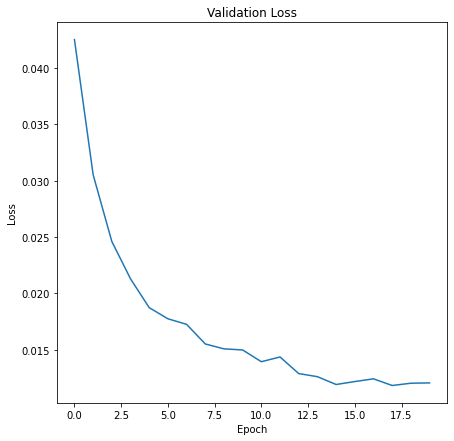

In [18]:
plot_graph(test_losses, "Loss")

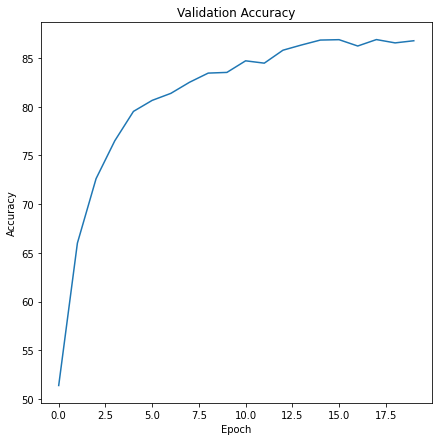

In [19]:
plot_graph(test_accs, "Accuracy")